In [1]:
!pip install -q git+https://github.com/tensorflow/docs

In [0]:
import urllib

import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.datasets import mnist
from tensorflow import keras
AUTOTUNE = tf.data.experimental.AUTOTUNE

import tensorflow_docs as tfdocs
from tensorflow_docs import plots

import PIL.Image

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['figure.figsize'] = (12,5)

24576/17858 [=========================================] - 0s 0us/step


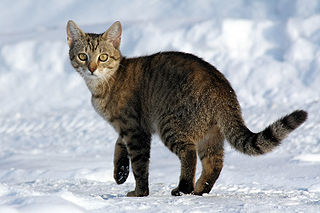

In [4]:
image_path = keras.utils.get_file('cat.jpg', "https://storage.googleapis.com/download.tensorflow.org/example_images/320px-Felis_catus-cat_on_snow.jpg")
PIL.Image.open(image_path)

In [0]:
image_string = tf.io.read_file(image_path)
image = tf.image.decode_jpeg(image_string, channels=3)

In [0]:
def visualize(original, augmented):
    fig = plt.figure()
    plt.subplot(1,2,1)
    plt.title('Original Image')
    plt.imshow(image)

    plt.subplot(1,2,2)
    plt.title('Augemented Image')
    plt.imshow(augmented)

### Flipping

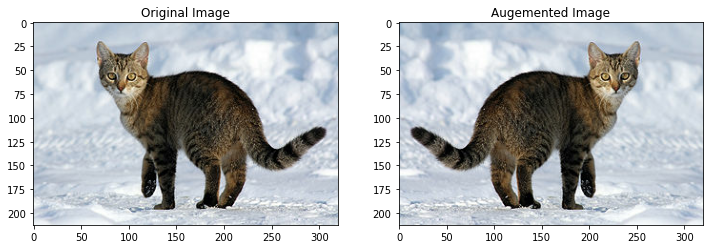

In [14]:
flipped = tf.image.flip_left_right(image)
visualize(image, flipped)

### Grayscaling

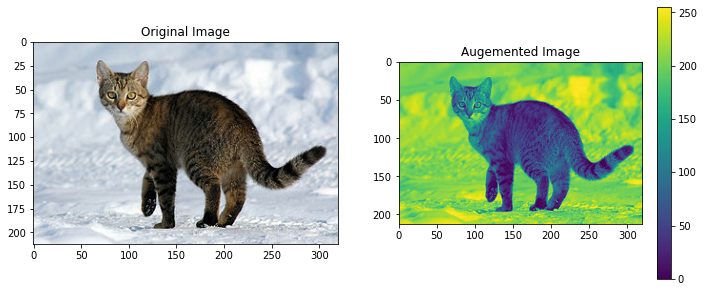

In [15]:
grayscaled = tf.image.rgb_to_grayscale(image)
visualize(image, tf.squeeze(grayscaled))
plt.colorbar()

### Saturate

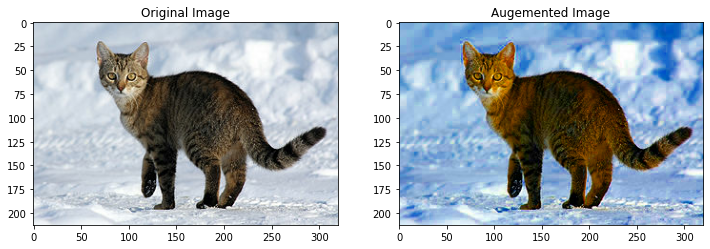

In [16]:
saturated = tf.image.adjust_saturation(image, 4)
visualize(image, saturated)

### Brighten

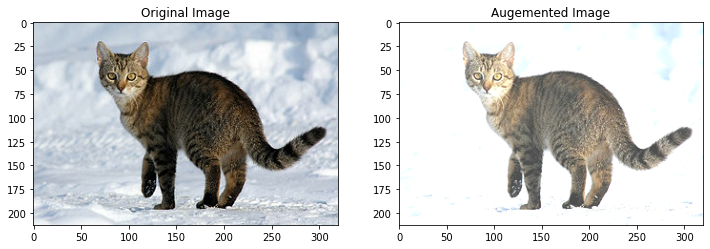

In [19]:
brightened = tf.image.adjust_brightness(image, 0.3)
visualize(image, brightened)

### Rotate

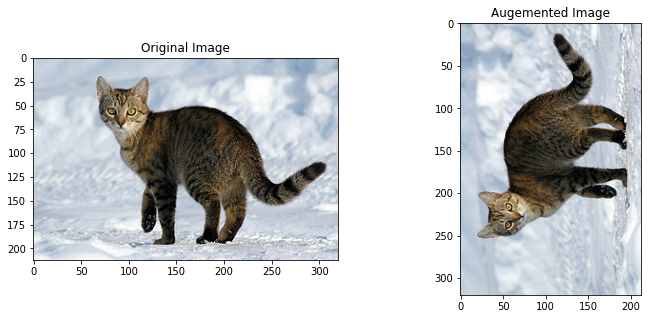

In [20]:
rotated = tf.image.rot90(image)
visualize(image, rotated)

### Center Crop

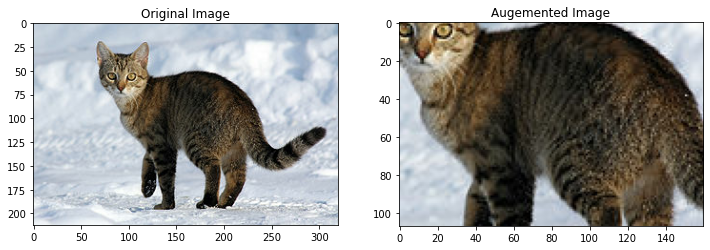

In [21]:
cropped = tf.image.central_crop(image, 0.5)
visualize(image, cropped)

## Model Training and Comparisons

In [0]:
dataset, info = tfds.load('mnist', as_supervised=True, with_info=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

num_train_examples = info.splits['train'].num_examples

In [0]:
def convert(image, label):
    image = tf.image.convert_image_dtype(image, tf.float32)
    return image, label

def augment(image, label):
    image, label = convert(image, label)
    image = tf.image.resize_with_crop_or_pad(image, 34, 34)
    image = tf.image.random_crop(image, size=[28,28,1])
    image = tf.image.random_brightness(image, max_delta=0.5)
    return image, label

In [0]:
BATCH_SIZE = 64
NUM_EXAMPLES = 2048

In [0]:
augmented_train_batches = (
    train_dataset
    .take(NUM_EXAMPLES).cache()
    .shuffle(num_train_examples//4)
    .map(augment, num_parallel_calls=AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
)

non_augmented_train_batch = (
    train_dataset
    .take(NUM_EXAMPLES).cache()
    .shuffle(num_train_examples//4)
    .map(convert, num_parallel_calls=AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
)

In [0]:
validation_batches = (
    test_dataset
    .map(convert, num_parallel_calls=AUTOTUNE)
    .batch(2*BATCH_SIZE)
)

In [0]:
def make_model():
    model = keras.Sequential([
                              keras.layers.Flatten(input_shape=(28,28,1)),
                              keras.layers.Dense(4096, activation='relu'),
                              keras.layers.Dense(4096, activation='relu'),
                              keras.layers.Dense(10)
    ])
    model.compile(optimizer='adam', loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
    return model

In [33]:
model_without_aug = make_model()

no_aug_history = model_without_aug.fit(non_augmented_train_batch, epochs=50, validation_data=validation_batches)

Epoch 1/50
32/32 [==============================] - 2s 66ms/step - loss: 0.8353 - accuracy: 0.7637 - val_loss: 0.3469 - val_accuracy: 0.8984
Epoch 2/50
32/32 [==============================] - 2s 64ms/step - loss: 0.1514 - accuracy: 0.9507 - val_loss: 0.3242 - val_accuracy: 0.9128
Epoch 3/50
32/32 [==============================] - 2s 65ms/step - loss: 0.0849 - accuracy: 0.9731 - val_loss: 0.3118 - val_accuracy: 0.9179
Epoch 4/50
32/32 [==============================] - 2s 64ms/step - loss: 0.0382 - accuracy: 0.9858 - val_loss: 0.3304 - val_accuracy: 0.9238
Epoch 5/50
32/32 [==============================] - 2s 64ms/step - loss: 0.0280 - accuracy: 0.9917 - val_loss: 0.3121 - val_accuracy: 0.9285
Epoch 6/50
32/32 [==============================] - 2s 63ms/step - loss: 0.0230 - accuracy: 0.9927 - val_loss: 0.3844 - val_accuracy: 0.9198
Epoch 7/50
32/32 [==============================] - 2s 63ms/step - loss: 0.0240 - accuracy: 0.9917 - val_loss: 0.4686 - val_accuracy: 0.9112
Epoch 8/50
32

In [34]:
model_with_aug = make_model()

aug_history = model_with_aug.fit(augmented_train_batches, epochs=50, validation_data=validation_batches)

Epoch 1/50
32/32 [==============================] - 2s 65ms/step - loss: 2.2755 - accuracy: 0.3115 - val_loss: 1.1915 - val_accuracy: 0.7019
Epoch 2/50
32/32 [==============================] - 2s 64ms/step - loss: 1.2728 - accuracy: 0.5767 - val_loss: 0.7002 - val_accuracy: 0.7956
Epoch 3/50
32/32 [==============================] - 2s 64ms/step - loss: 0.9248 - accuracy: 0.6924 - val_loss: 0.4468 - val_accuracy: 0.8725
Epoch 4/50
32/32 [==============================] - 2s 63ms/step - loss: 0.7633 - accuracy: 0.7417 - val_loss: 0.4729 - val_accuracy: 0.8500
Epoch 5/50
32/32 [==============================] - 2s 62ms/step - loss: 0.6507 - accuracy: 0.7764 - val_loss: 0.3748 - val_accuracy: 0.8815
Epoch 6/50
32/32 [==============================] - 2s 63ms/step - loss: 0.6387 - accuracy: 0.7896 - val_loss: 0.3531 - val_accuracy: 0.8873
Epoch 7/50
32/32 [==============================] - 2s 65ms/step - loss: 0.4779 - accuracy: 0.8472 - val_loss: 0.3037 - val_accuracy: 0.9042
Epoch 8/50
32

(0.75, 1.0)

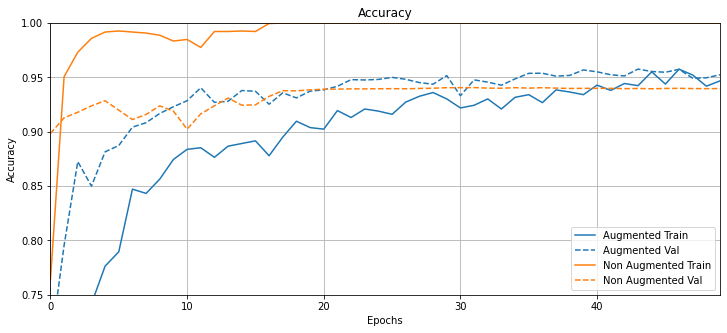

In [36]:
plotter = tfdocs.plots.HistoryPlotter()
plotter.plot({'Augmented': aug_history, 'Non Augmented': no_aug_history}, metric='accuracy')
plt.title('Accuracy')
plt.ylim([0.75,1])

(0.0, 1.0)

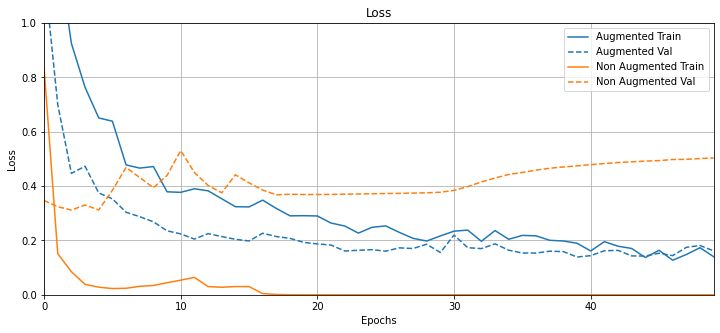

In [37]:
plotter.plot({'Augmented': aug_history, 'Non Augmented': no_aug_history}, metric='loss')
plt.title('Loss')
plt.ylim([0,1])